# Analyse des continents et des nationalités


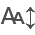

In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [4]:
## define SPARQL enpoint
endpoint = "https://ag15yee0az6rmk64.allegrograph.cloud/repositories/ceos"

In [5]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) 
            ( GROUP_CONCAT(DISTINCT ?genderLabel; separator=", ") AS ?genders ) 
            ( GROUP_CONCAT(DISTINCT ?countryLabel; separator=", ") AS ?countries )
            ( GROUP_CONCAT(DISTINCT ?continentLabel; separator=", ") AS ?continents )
            ( GROUP_CONCAT(DISTINCT ?occupationLabel; separator=", ") AS ?occupations )
WHERE {
    GRAPH  <https://github.com/Laillaa/French_CEOs/blob/main/graphs/Wikidata-imported-data.md>
        {?s wdt:P21 ?gender;
            rdfs:label ?label;
            wdt:P569 ?birthDate;
            wdt:P27 ?country.
        ?gender rdfs:label ?genderLabel.
        ?country rdfs:label ?countryLabel.
        ?country wdt:P30 ?continent.
        ?continent rdfs:label ?continentLabel.
        OPTIONAL {  ?s wdt:P106 ?occupation.
                    ?occupation rdfs:label ?occupationLabel.}

        ## Excluding Australia and Oceania insular
        # Eurasia : wd:Q5401 
        FILTER ( ?continent NOT IN ( wd:Q3960, wd:Q538))
          }
}
GROUP BY ?s
"""

In [6]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [7]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

2555


[['http://www.wikidata.org/entity/Q7151785',
  'Paul King',
  '1984',
  'male',
  'United States',
  'North America',
  'chief executive officer, entrepreneur'],
 ['http://www.wikidata.org/entity/Q562917',
  'Steve Case',
  '1958',
  'male',
  'United States',
  'North America',
  'chief executive officer, businessperson'],
 ['http://www.wikidata.org/entity/Q12316216',
  'Henning Axel Nielsen',
  '1938',
  'male',
  'Kingdom of Denmark',
  'Europe',
  'chief executive officer, businessperson']]

In [8]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'gender', 'countries', 'continents', 'occupations']
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations
0,http://www.wikidata.org/entity/Q7151785,Paul King,1984,male,United States,North America,"chief executive officer, entrepreneur"
1,http://www.wikidata.org/entity/Q562917,Steve Case,1958,male,United States,North America,"chief executive officer, businessperson"
2,http://www.wikidata.org/entity/Q12316216,Henning Axel Nielsen,1938,male,Kingdom of Denmark,Europe,"chief executive officer, businessperson"
3,http://www.wikidata.org/entity/Q17052234,Stephen Siegel,1944,male,United States,North America,chief executive officer
4,http://www.wikidata.org/entity/Q2898568,Bernard Sabrier,1953,male,Morocco,Africa,"chief executive officer, businessperson"


In [9]:
## transformer les années en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [10]:
### Inspecter la structure du dataframe
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2555 entries, 0 to 2554
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    2555 non-null   object
 1   personLabel  2555 non-null   object
 2   birthYear    2555 non-null   int64 
 3   gender       2555 non-null   object
 4   countries    2555 non-null   object
 5   continents   2555 non-null   object
 6   occupations  2555 non-null   object
dtypes: int64(1), object(6)
memory usage: 139.9+ KB


In [11]:
### Store to CSV
f_path = '../df_continent_occupations_20250406.csv'
df_p.to_csv(f_path)

## Coder les continents et afficher leur distribution

In [12]:
### Inspecter les données
print(df_p.iloc[ :5 , :].continents)

0    North America
1    North America
2           Europe
3    North America
4           Africa
Name: continents, dtype: object


In [13]:
### Regrouper et compter
df_contCode = df_p.groupby('continents').size()
df_contCode.columns=['effectif']
df_contCode = pd.DataFrame(df_contCode.sort_values( ascending = False))
#df_contCode.reset_index(inplace=True)
print(df_contCode.head(10))

                          0
continents                 
Europe                 1114
Asia                    643
North America           501
Africa                  105
Oceania                  66
South America            47
Europe, Asia             25
North America, Europe     9
Asia, Europe              8
Asia, North America       6


In [14]:
### Créer une fonction de codage
def codeContinents(continents):
    
    if 'Europe, Asia' in continents:
        output = 'Eurasia'    
    elif 'Europe' in continents:
        output = 'Europe'
    elif 'Africa' in continents:
        output = 'Africa'
    elif 'Oceania' in continents:
        output = 'Oceania'
    ## Issue with Russia, Russian Empire, Wikidata not consistent    
    elif 'Eurasia' in continents:
        output = 'Eurasia'
    elif 'North America' in continents:
        output = 'NorthAmerica'   
    elif 'Asia' in continents:
        output = 'Asia'
    elif 'South America' in continents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [15]:
### Tester la fonction
print(codeContinents('Oceania, North America, Africa'))

Africa


In [16]:
### On ajoute une nouvelle colonne 'contCode' et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode
0,http://www.wikidata.org/entity/Q7151785,Paul King,1984,male,United States,North America,"chief executive officer, entrepreneur",NorthAmerica
1,http://www.wikidata.org/entity/Q562917,Steve Case,1958,male,United States,North America,"chief executive officer, businessperson",NorthAmerica
2,http://www.wikidata.org/entity/Q12316216,Henning Axel Nielsen,1938,male,Kingdom of Denmark,Europe,"chief executive officer, businessperson",Europe


In [17]:
### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)

              effectif
contCode              
Eurasia             28
SouthAmerica        47
Oceania             69
Africa             109
NorthAmerica       510
Asia               643
Europe            1149


In [18]:
### How to handle data about Russians
df_p[df_p.countries.str.contains('Russi')].head(7)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode
53,http://www.wikidata.org/entity/Q366524,Nikolai Ryzhkov,1929,male,Russia,Europe,"non-fiction writer, chief executive officer, s...",Europe
77,http://www.wikidata.org/entity/Q4223722,Valentin Klimov,1939,male,"Soviet Union, Russia","Europe, Asia","university teacher, chief executive officer, i...",Eurasia
102,http://www.wikidata.org/entity/Q47453276,Aleksandr Inozemtsev,1951,male,"Soviet Union, Russia","Europe, Asia","manager, university teacher, chief executive o...",Eurasia
103,http://www.wikidata.org/entity/Q104760616,Valentin Sushko,1932,male,"Soviet Union, United States, Russia","Europe, Asia, North America","chief executive officer, statesperson",Eurasia
130,http://www.wikidata.org/entity/Q124035147,Yury Klishin,1947,male,"Russia, Soviet Union","Europe, Asia","aircraft pilot, chief executive officer, milit...",Eurasia
185,http://www.wikidata.org/entity/Q21559001,Izrail Levin,1908,male,"Soviet Union, Russia, Russian Empire","Europe, Asia, North America, Eurasia","non-fiction writer, industrialist, chief execu...",Eurasia
232,http://www.wikidata.org/entity/Q18634567,Nikolay Maksimov,1911,male,"Soviet Union, Russian Empire","Europe, Asia, Eurasia, North America",chief executive officer,Eurasia


In [19]:
### Regrouper et compter les personnes issues de Russie
df_contCode = df_p[df_p.countries.str.contains('ussi')].groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)

          effectif
contCode          
Eurasia         13
Europe          22


In [20]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p.iloc[ 97:101 , : ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode
97,http://www.wikidata.org/entity/Q8421760,Jay Walder,1958,male,United States,North America,chief executive officer,NorthAmerica
98,http://www.wikidata.org/entity/Q107749830,Udi Adiri,1977,male,Israel,Asia,chief executive officer,Asia
99,http://www.wikidata.org/entity/Q16105139,David Komansky,1939,male,United States,North America,"business executive, chief executive officer, c...",NorthAmerica
100,http://www.wikidata.org/entity/Q12411844,Simcha Even-Zohar,1905,male,Israel,Asia,chief executive officer,Asia


In [21]:
# Count persons with more than one country (pluri-nationality)
df_p['n_countries'] = df_p['countries'].apply(lambda x: len(x.split(',')))
pluri_national = df_p[df_p['n_countries'] > 1]
print(f"Number of persons with pluri-nationality: {len(pluri_national)}")
print(f"Percentage: {100 * len(pluri_national) / len(df_p):.2f}%")

Number of persons with pluri-nationality: 114
Percentage: 4.46%


In [22]:
# On separe les gens avec plus d'un pays et ceux avec un seul pays
df_p_single_country = df_p[df_p['n_countries'] == 1]
df_p_multi_country = df_p[df_p['n_countries'] > 1]
# Count persons with more than one country
print(f"Number of persons with single country: {len(df_p_single_country)}")
print(f"Number of persons with multiple countries: {len(df_p_multi_country)}")


Number of persons with single country: 2441
Number of persons with multiple countries: 114


In [23]:
from collections import Counter

# Flatten df_p_single_country into a list
single_country_list = df_p_single_country['countries'].str.split(', ').explode().tolist()
# Count occurrences of each country
country_counts = Counter(single_country_list)
# Convert to DataFrame
df_country_counts = pd.DataFrame(country_counts.items(), columns=['country', 'count'])
# Sort by count
df_country_counts = df_country_counts.sort_values(by='count', ascending=False)
# Display the top 10 countries
print(df_country_counts)

            country  count
8            Israel    445
0     United States    431
3            France    266
10   United Kingdom    117
27           Sweden    101
..              ...    ...
107        Bulgaria      1
108      Bangladesh      1
109     The Bahamas      1
110        Slovakia      1
111          Jordan      1

[112 rows x 2 columns]


### Distribution des nationalités: représentation graphique

In [24]:
### Regrouper et compter df_country_counts
### sort by effectif descending
df_country_counts = df_p_single_country.groupby('countries').size()
df_country_counts = pd.DataFrame(df_country_counts.sort_values(ascending=False))
df_country_counts.columns = ['effectif']

df_country_counts['frequence'] = (100 * df_country_counts['effectif'] \
                                   / df_country_counts['effectif'].sum()).round(2)
df_country_counts

,effectif,frequence
countries,,
Israel,445,18.23
United States,431,17.66
France,266,10.90
United Kingdom,117,4.79
Sweden,101,4.14
...,...,...
Timor-Leste,1,0.04
Uzbekistan,1,0.04
United Kingdom of Great Britain and Ireland,1,0.04


C:\Users\laila\AppData\Local\Temp\ipykernel_2176\3028909561.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='effectif', y=df_country_counts.index, data=df_country_counts, palette='viridis')


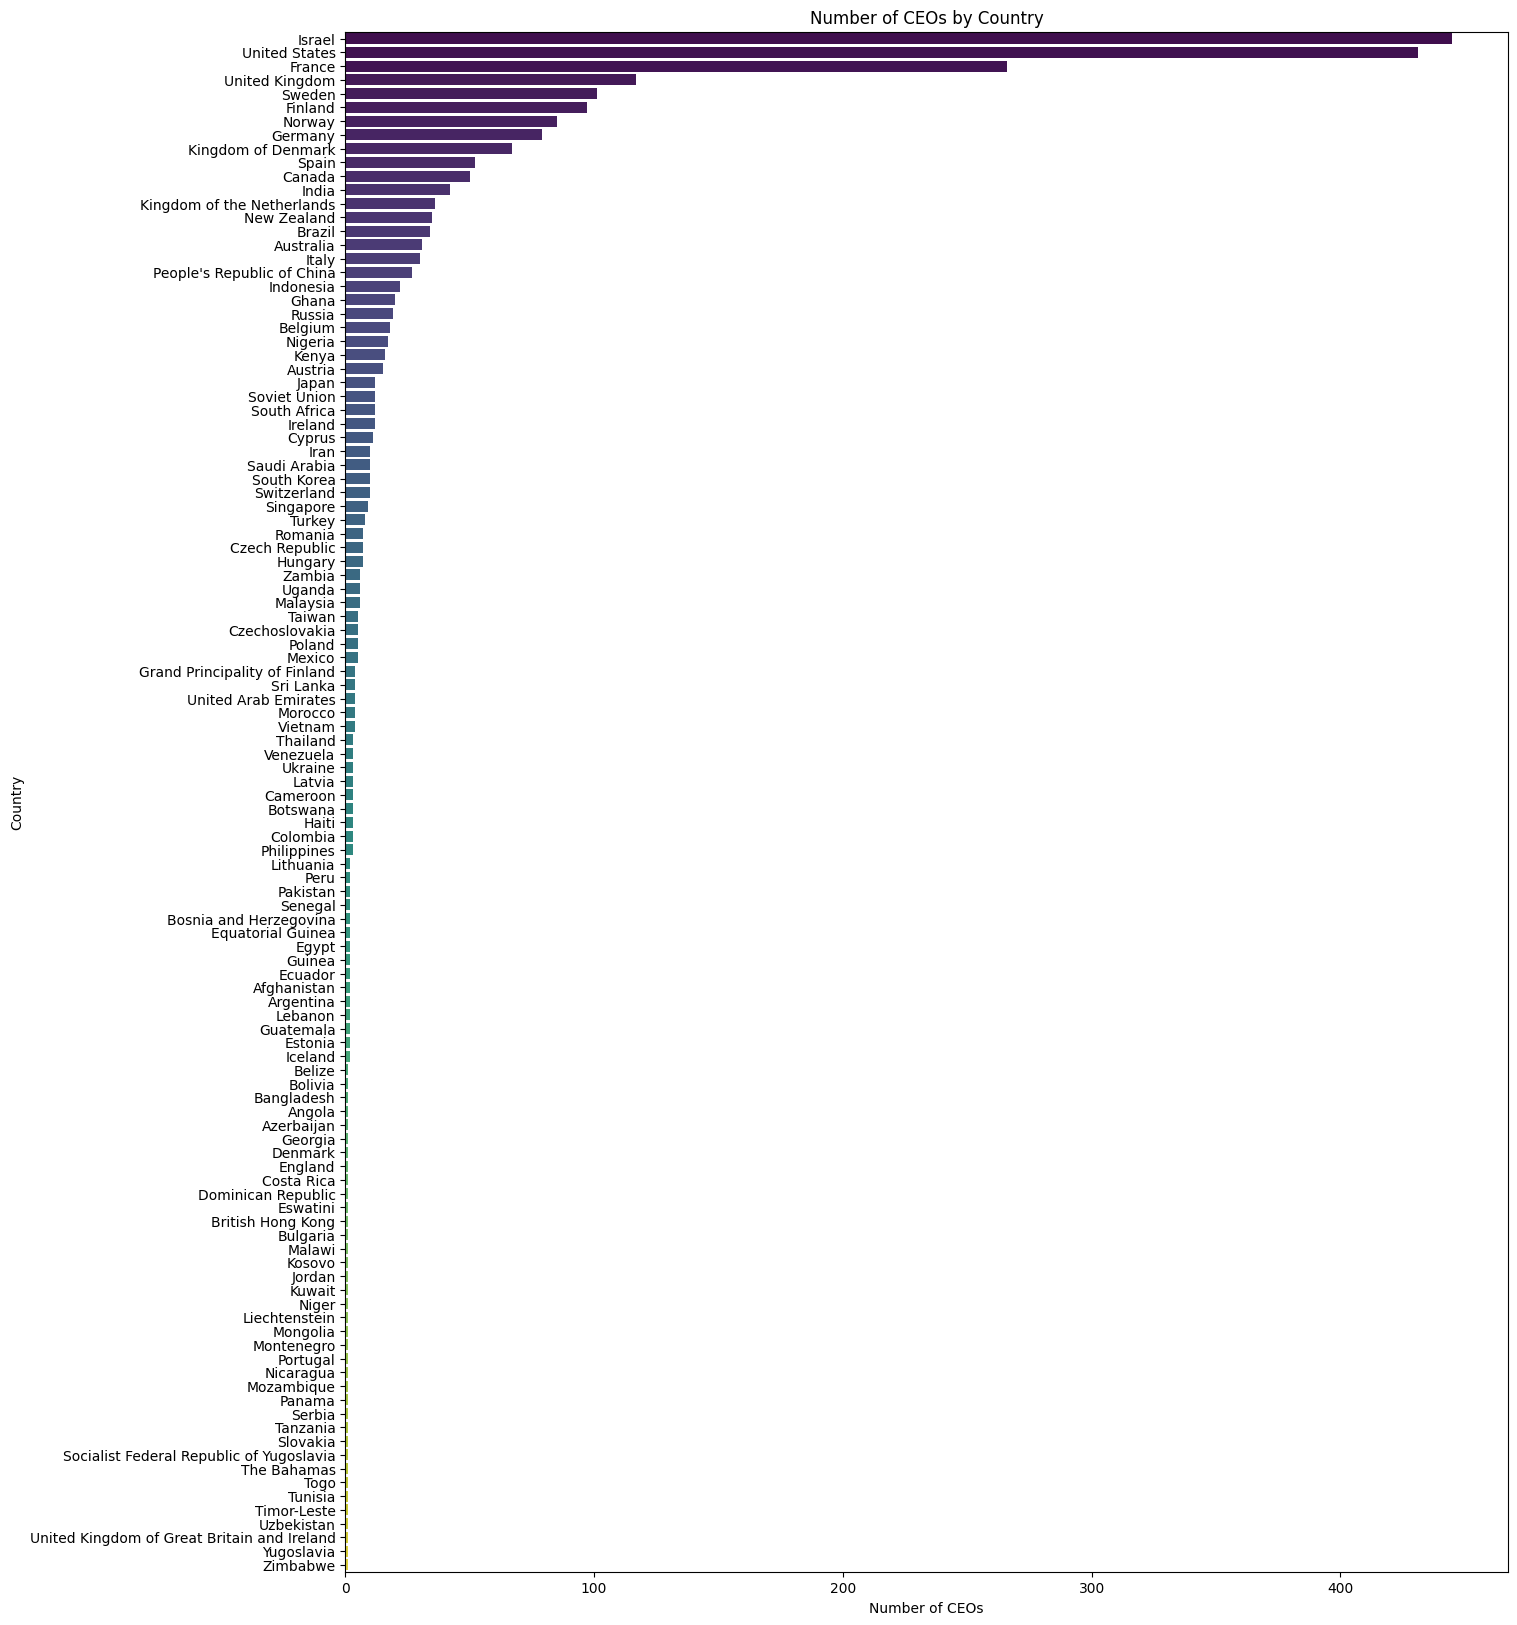

In [25]:
# plot df_country_counts, horizontal bar plot
plt.figure(figsize=(15, 20))
sns.barplot(x='effectif', y=df_country_counts.index, data=df_country_counts, palette='viridis')
plt.title('Number of CEOs by Country')
plt.xlabel('Number of CEOs')
plt.ylabel('Country')
plt.show()

### Codage par période de vingt-cinq ans

In [26]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1751, 2025, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1751, 1776, 1801, 1826, 1851] [1901, 1926, 1951, 1976, 2001] 10


In [27]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [28]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode,n_countries,per_25
0,http://www.wikidata.org/entity/Q7151785,Paul King,1984,male,United States,North America,"chief executive officer, entrepreneur",NorthAmerica,1,1976-2000
1,http://www.wikidata.org/entity/Q562917,Steve Case,1958,male,United States,North America,"chief executive officer, businessperson",NorthAmerica,1,1951-1975
2,http://www.wikidata.org/entity/Q12316216,Henning Axel Nielsen,1938,male,Kingdom of Denmark,Europe,"chief executive officer, businessperson",Europe,1,1926-1950


In [29]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25').size()
print(naissances_per)

per_25
1751-1775       1
1776-1800       2
1801-1825       6
1826-1850      12
1851-1875      30
1876-1900      74
1901-1925     143
1926-1950     443
1951-1975    1390
1976-2000     454
dtype: int64


C:\Users\laila\AppData\Local\Temp\ipykernel_2176\173774721.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  naissances_per = df_p.groupby(by='per_25').size()


C:\Users\laila\AppData\Local\Temp\ipykernel_2176\1845055184.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = df_p.groupby(by='per_25').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))


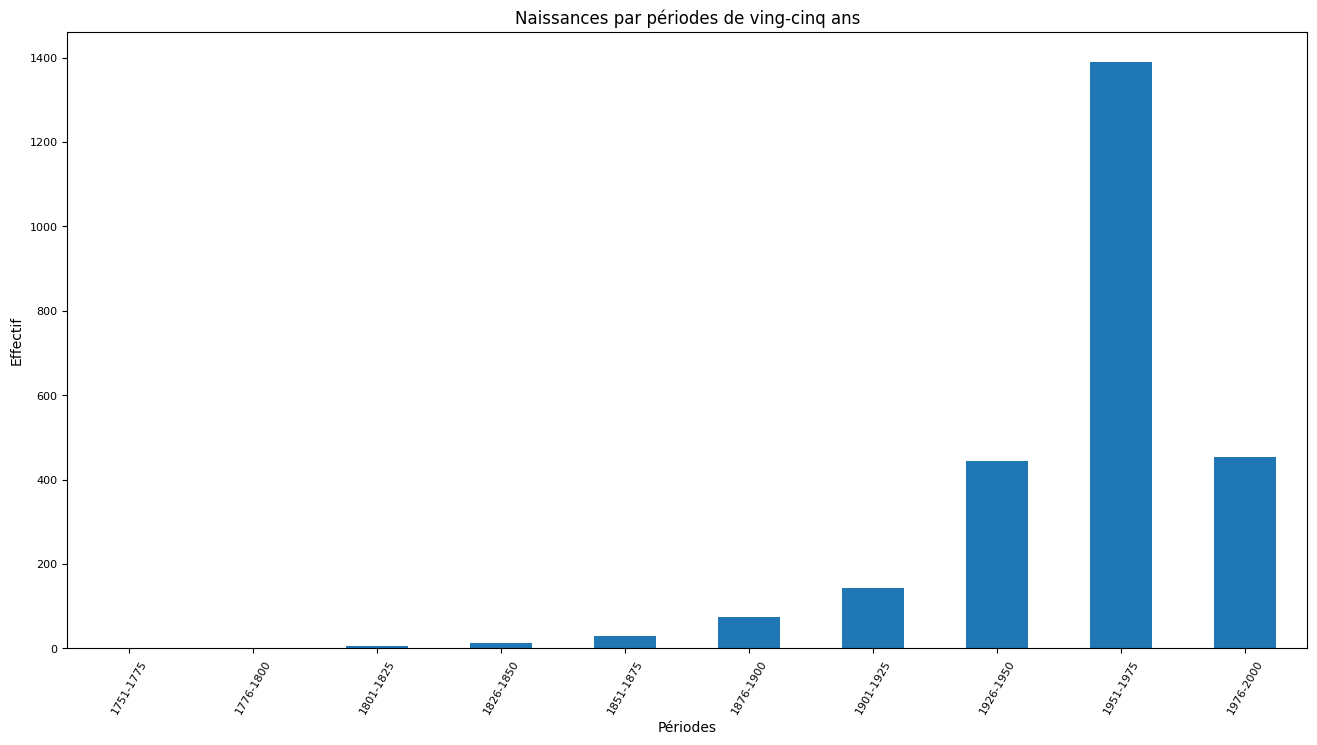

In [30]:
### Diagramme à barres représentant la distribution par 'génération'
ax = df_p.groupby(by='per_25').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de ving-cinq ans')
plt.show()

## Ajouter la représentation des continents

In [31]:
lcont = list(sorted(set(df_p.contCode.to_list())))
lcont.remove('Europe')
print(lcont)

['Africa', 'Asia', 'Eurasia', 'NorthAmerica', 'Oceania', 'SouthAmerica']


In [32]:
### Regrouper et compter avec un fitre sur le continent 'Europe'
merged = pd.DataFrame(df_p[df_p.contCode == 'Europe'].groupby('per_25').size())
merged.columns = ['Europe']
merged.tail()

C:\Users\laila\AppData\Local\Temp\ipykernel_2176\1392117409.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged = pd.DataFrame(df_p[df_p.contCode == 'Europe'].groupby('per_25').size())


,Europe
per_25,
1876-1900,57
1901-1925,70
1926-1950,129
1951-1975,657
1976-2000,191


In [33]:
### Ajouter les distributions des autres continents
for cont in lcont:
    new_df = pd.DataFrame(df_p[df_p.contCode == cont].groupby('per_25').size())
    new_df.columns = [cont]
    merged = pd.merge(merged, new_df, left_index=True, right_index=True)

### Enlever les 2 premières lignes (1751-1775 et 1776-1800) car les valeurs sont nulles
merged = merged.iloc[2: , :]
merged    


C:\Users\laila\AppData\Local\Temp\ipykernel_2176\2553485247.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_df = pd.DataFrame(df_p[df_p.contCode == cont].groupby('per_25').size())
C:\Users\laila\AppData\Local\Temp\ipykernel_2176\2553485247.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_df = pd.DataFrame(df_p[df_p.contCode == cont].groupby('per_25').size())
C:\Users\laila\AppData\Local\Temp\ipykernel_2176\2553485247.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observ

,Europe,Africa,Asia,Eurasia,NorthAmerica,Oceania,SouthAmerica
per_25,,,,,,,
1801-1825,6,0,0,0,0,0,0
1826-1850,11,0,0,0,0,1,0
1851-1875,25,0,0,0,4,1,0
1876-1900,57,0,7,2,6,2,0
1901-1925,70,0,41,11,19,2,0
1926-1950,129,9,173,7,97,22,6
1951-1975,657,49,325,8,289,31,31
1976-2000,191,51,97,0,95,10,10


In [34]:
### Transformer l'index en chaîne de caractères
# ce qui est indispensable pour l'affichage dans un graphique
merged.index = merged.index.map(str)
merged

,Europe,Africa,Asia,Eurasia,NorthAmerica,Oceania,SouthAmerica
per_25,,,,,,,
1801-1825,6,0,0,0,0,0,0
1826-1850,11,0,0,0,0,1,0
1851-1875,25,0,0,0,4,1,0
1876-1900,57,0,7,2,6,2,0
1901-1925,70,0,41,11,19,2,0
1926-1950,129,9,173,7,97,22,6
1951-1975,657,49,325,8,289,31,31
1976-2000,191,51,97,0,95,10,10


In [39]:
### Adapter à l'ordre des colonnes
col_palette_1 = [
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : Africa
    "#F4A261",  # Light Coral: Asia
    "#F6E58D",  # Light Yellow :Eurasia
    "#B2E0B2",  # Light Green : North America
    "#A3C1DA",  # Light Blue : Oceania  
    "#FFB6C1"   # Light Pink : South America  

]


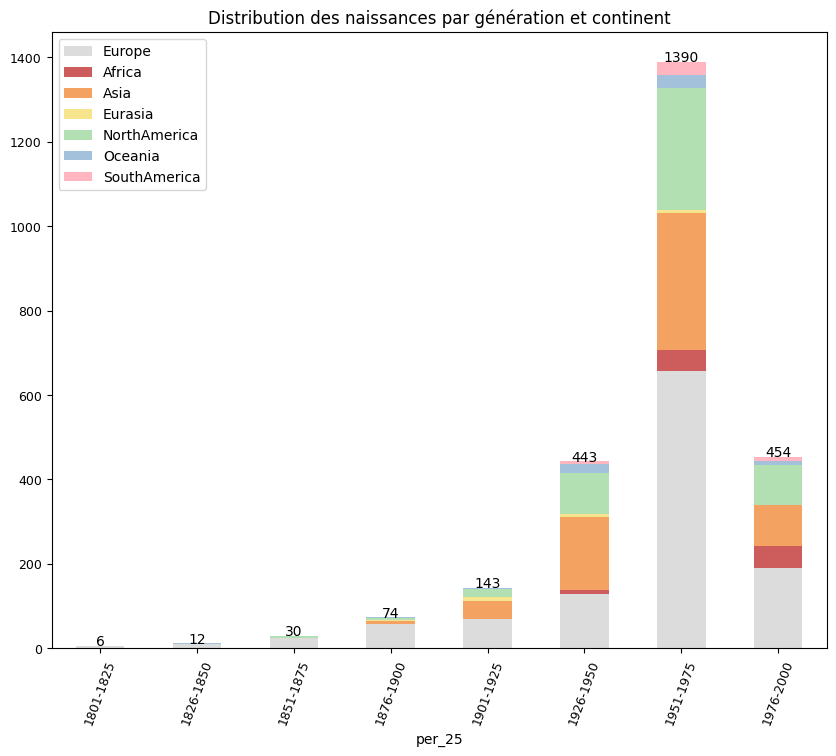

In [ ]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = merged

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), 
                     color=col_palette_1)
plt.title('Distribution des naissances par génération et continent')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
for x, y in enumerate(data.sum(axis=1)):
    ax.annotate(y, (x, y+0.1), ha='center') 


plt.show()